# GPT Annotations EDA

In [1]:
!conda env list

# conda environments:
#
base                     /Users/kylehamilton/opt/anaconda3
annotation            *  /Users/kylehamilton/opt/anaconda3/envs/annotation
mapping                  /Users/kylehamilton/opt/anaconda3/envs/mapping
mlflow                   /Users/kylehamilton/opt/anaconda3/envs/mlflow
nlp                      /Users/kylehamilton/opt/anaconda3/envs/nlp
pyg                      /Users/kylehamilton/opt/anaconda3/envs/pyg
si                       /Users/kylehamilton/opt/anaconda3/envs/si
torch                    /Users/kylehamilton/opt/anaconda3/envs/torch
transformers             /Users/kylehamilton/opt/anaconda3/envs/transformers



In [38]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re

In [3]:
conn = utils.connectDB()

In [148]:
conn.close()

In [4]:
query = 'SELECT  count(*) as NumValues FROM ebdb.PTC_annotations where answer="yes" group by PTC_id;'
df = pd.read_sql(query, conn)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:ylabel='Frequency'>

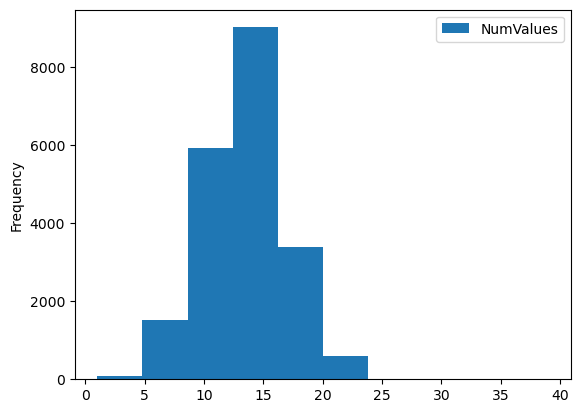

In [5]:
df.plot(kind="hist")

In [6]:
query = 'SELECT  count(*) as count, property FROM ebdb.PTC_annotations \
            where answer="yes" \
            group by property \
            order by count;'

df = pd.read_sql(query, conn)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [7]:
# df = df.sort_values('count', ascending=True)

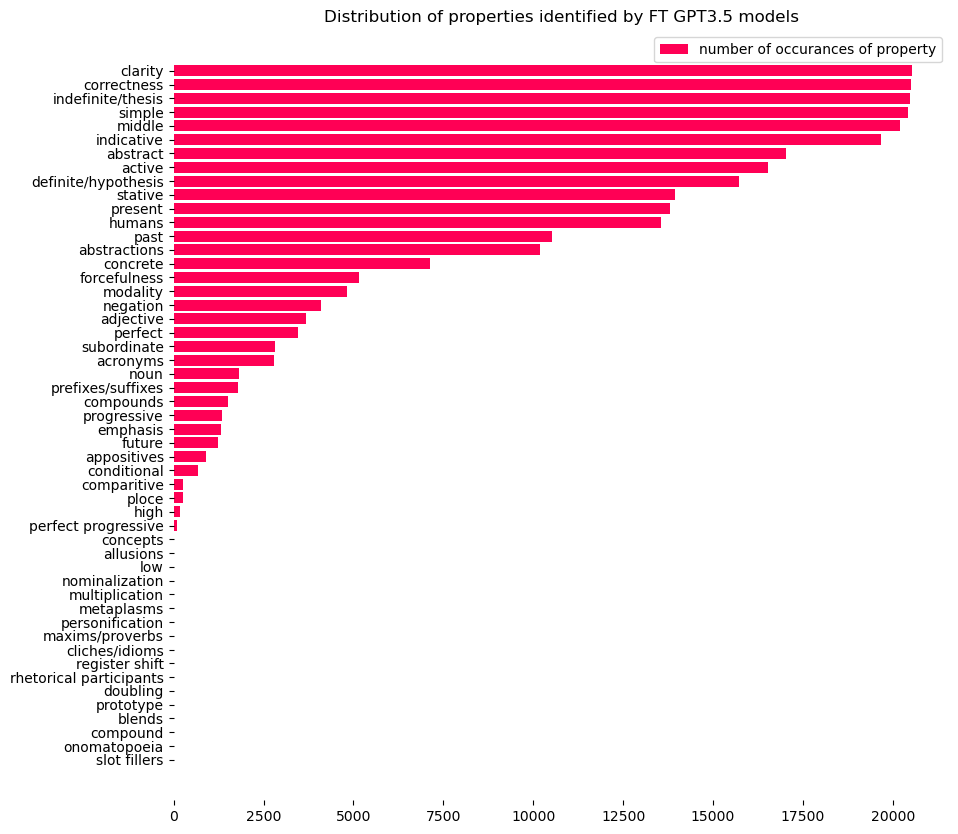

In [8]:
fig, ax = plt.subplots(figsize=[10,10])
ax.barh(df['property'],df['count'], color="#ff0055", label="number of occurances of property")
ax.set_frame_on(False)
ax.set_title('Distribution of properties identified by FT GPT3.5 models')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0))
# fig.savefig("gpt_exact_barh.svg",format="svg")
plt.show()

# Calculate the correlations between properties and propaganda techniques

1. binary
2. per technique

In [9]:
import numpy as np
import scipy.stats
from collections import defaultdict
from tqdm import tqdm

In [10]:
conn = utils.connectDB()
query = 'SELECT distinct(property), feature FROM ebdb.PTC_annotations where answer="yes";'

df = pd.read_sql(query, conn)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
# df.to_dict('records')
feature_prop_dict = dict(map(lambda i,j : (i,j) , df['property'],df['feature']))
feature_prop_dict

{'simple': 'Aspect',
 'correctness': 'Language varieties',
 'clarity': 'Language varieties',
 'middle': 'Language varieties',
 'abstract': 'Lexical and semantic fields',
 'concrete': 'Lexical and semantic fields',
 'indefinite/thesis': 'Lexical and semantic fields',
 'definite/hypothesis': 'Lexical and semantic fields',
 'indicative': 'Mood',
 'active': 'Predication',
 'humans': 'Subject choices',
 'abstractions': 'Subject choices',
 'perfect': 'Aspect',
 'emphasis': 'Figures of word choice',
 'forcefulness': 'Language varieties',
 'appositives': 'Phrases built on nouns',
 'stative': 'Predication',
 'present': 'Tense',
 'progressive': 'Aspect',
 'adjective': 'Modifying clauses',
 'past': 'Tense',
 'subordinate': 'Modifying clauses',
 'modality': 'Verb choices',
 'acronyms': 'New words and changing uses',
 'negation': 'Verb choices',
 'noun': 'Modifying clauses',
 'prefixes/suffixes': 'New words and changing uses',
 'compounds': 'New words and changing uses',
 'comparitive': 'Modifying 

In [12]:
properties = list(df['property'])

In [13]:
len(properties)

51

In [40]:
techniques = ['Appeal_to_Authority',
             'Appeal_to_fear-prejudice',
             'Bandwagon',
             'Black-and-White_Fallacy',
             'Causal_Oversimplification',
             'Doubt',
             'Exaggeration,Minimisation',
             'Flag-Waving',
             'Loaded_Language',
             'Name_Calling,Labeling',
             'Obfuscation,Intentional_Vagueness,Confusion',
             'Red_Herring',
             'Reductio_ad_hitlerum',
             'Repetition',
             'Slogans',
             'Straw_Men',
             'Thought-terminating_Cliches',
             'Whataboutism',
             'Not_Propaganda']

In [108]:
properties

['simple',
 'correctness',
 'clarity',
 'middle',
 'abstract',
 'concrete',
 'indefinite/thesis',
 'definite/hypothesis',
 'indicative',
 'active',
 'humans',
 'abstractions',
 'perfect',
 'emphasis',
 'forcefulness',
 'appositives',
 'stative',
 'present',
 'progressive',
 'adjective',
 'past',
 'subordinate',
 'modality',
 'acronyms',
 'negation',
 'noun',
 'prefixes/suffixes',
 'compounds',
 'comparitive',
 'future',
 'high',
 'conditional',
 'ploce',
 'perfect progressive',
 'low',
 'concepts',
 'allusions',
 'compound',
 'nominalization',
 'doubling',
 'prototype',
 'onomatopoeia',
 'rhetorical participants',
 'metaplasms',
 'register shift',
 'cliches/idioms',
 'maxims/proverbs',
 'personification',
 'multiplication',
 'blends',
 'slot fillers']

In [17]:
def makeTArr(s):
    tArr = [0]*19
    
    if type(s) == list:
        if len(s) == 0:
            s = [18]
        for i in s:
            tArr[i] = 1
    else:
        try:
            _list = ast.literal_eval(s)
            if len(_list) == 0:
                _list = [18]
            for i in _list:
                tArr[i] = 1
        except Exception as e:
            print(e,"-->",s)
    
    return np.array(tArr)

In [ ]:
def makeTArr(s):
    
    tArr = [0]*19
    
    if type(s) == list:
        
        if len(s) == 0:
            s = [18]
        for i in s:
            tArr[i] = 1
    else:
        try:
            _list = [re.sub(r"[\[\]]","",i) for i in s.split(",")]
            _list = [int(i) for i in _list if i != '']

            if len(_list) == 0:
                _list = [18]
                
            for i in _list:
                tArr[i] = 1
                
        except Exception as e:
            print(e,"-->",s)
    
    return tArr

In [94]:
x = np.array([1, 0, 0, 0])
y = np.array([1, 0, 1, 1])

a = sum(x + y == 2)
b = sum((x == 0) & (y == 1))
c = sum((x == 1) & (y == 0))
d = sum(x + y == 0)
print(a,b,c,d)

1 2 0 1


In [144]:
conn = utils.connectDB()
# properties = ['forcefulness']

def str_to_list(s):
    s = [int(re.sub(r"[\[\]]","",i)) for i in s.split(" ")]
    return s

correlations     = defaultdict(list)
Q_table          = defaultdict(list)
frequencies      = defaultdict(list)
phi_coefficients = defaultdict(list)

# RC_table = [[0]*19]*len(properties)
# count = 0

for prop in tqdm(properties):
    
    """
    query = f'SELECT pa.answer, p.labels, p.technique_classification FROM ebdb.PTC_annotations as pa \
            JOIN ebdb.PTC as p on pa.PTC_id = p.id \
            WHERE pa.property = "{prop}";'
    
    df = pd.read_sql(query, conn)
    df['answer'] = df['answer'].apply(lambda x: 0 if x=='no' else 1)
    df['techniques'] = df['technique_classification'].apply(makeTArr)
    
    df.to_csv("data/correlations/"+prop.replace("/","-")+".csv", index=None)
    """
    
    df = pd.read_csv("data/correlations/"+prop.replace("/","-")+".csv")
    df["techniques"] = df["techniques"].apply(lambda x: str_to_list(x))
    
    
    # y = df['labels']
    # x = df['answer']
    # correlations[prop] = [p_r, p]
    
    
    long_property = feature_prop_dict[prop]+" - "+prop

    x = df['answer']
    
    for i in range(0,19):
        
        y = df['techniques'].apply(lambda z: z[i])
        
        p_r, p = scipy.stats.pearsonr(x, y)
        correlations[long_property].append([p_r,p])
        
        """
        make conttingency table
        
                     X
               |  1   0
           --------------
        Y   1  |  a   b
            0  |  c   d
        
        calculate Yules Q
        
        Q = (ad - bc) / (ad + bc)
        
        """
        
        a = sum(x + y == 2)
        b = sum((x == 0) & (y == 1))
        c = sum((x == 1) & (y == 0))
        d = sum(x + y == 0)
        
        Q = (a*d - b*c)/(a*d + b*c)
        
        phi = (a*d - b*c)/np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
        
        Q_table[long_property].append(Q)
        frequencies[long_property].append(a)
        phi_coefficients[long_property].append(phi)
    
# pd.DataFrame(correlations).to_csv("data/correlations/pearsons.csv",index=None)

100%|███████████████████████████████████████████| 51/51 [01:07<00:00,  1.31s/it]


# Phi

In [145]:
phi_coefficients

defaultdict(list,
            {'Aspect - simple': [0.007027226374970049,
              0.010414340293241352,
              0.0022153790307546458,
              0.005963019647877438,
              0.008496043447134907,
              0.00951132110716877,
              0.013630509931603148,
              0.004663753235057578,
              0.015612219038256749,
              0.015153865347134159,
              0.002293190967394782,
              0.003554413377549488,
              0.004314540738440144,
              0.00586059609738551,
              0.007226631027372988,
              0.002050942606009024,
              0.0053374752022016985,
              0.005031114369891446,
              -0.03093780080805388],
             'Language varieties - correctness': [0.004517723483306072,
              0.006695262962968019,
              0.001424241419155968,
              0.0038335567892058956,
              0.005462010024965334,
              0.00854308540445551,
              0.0087629070

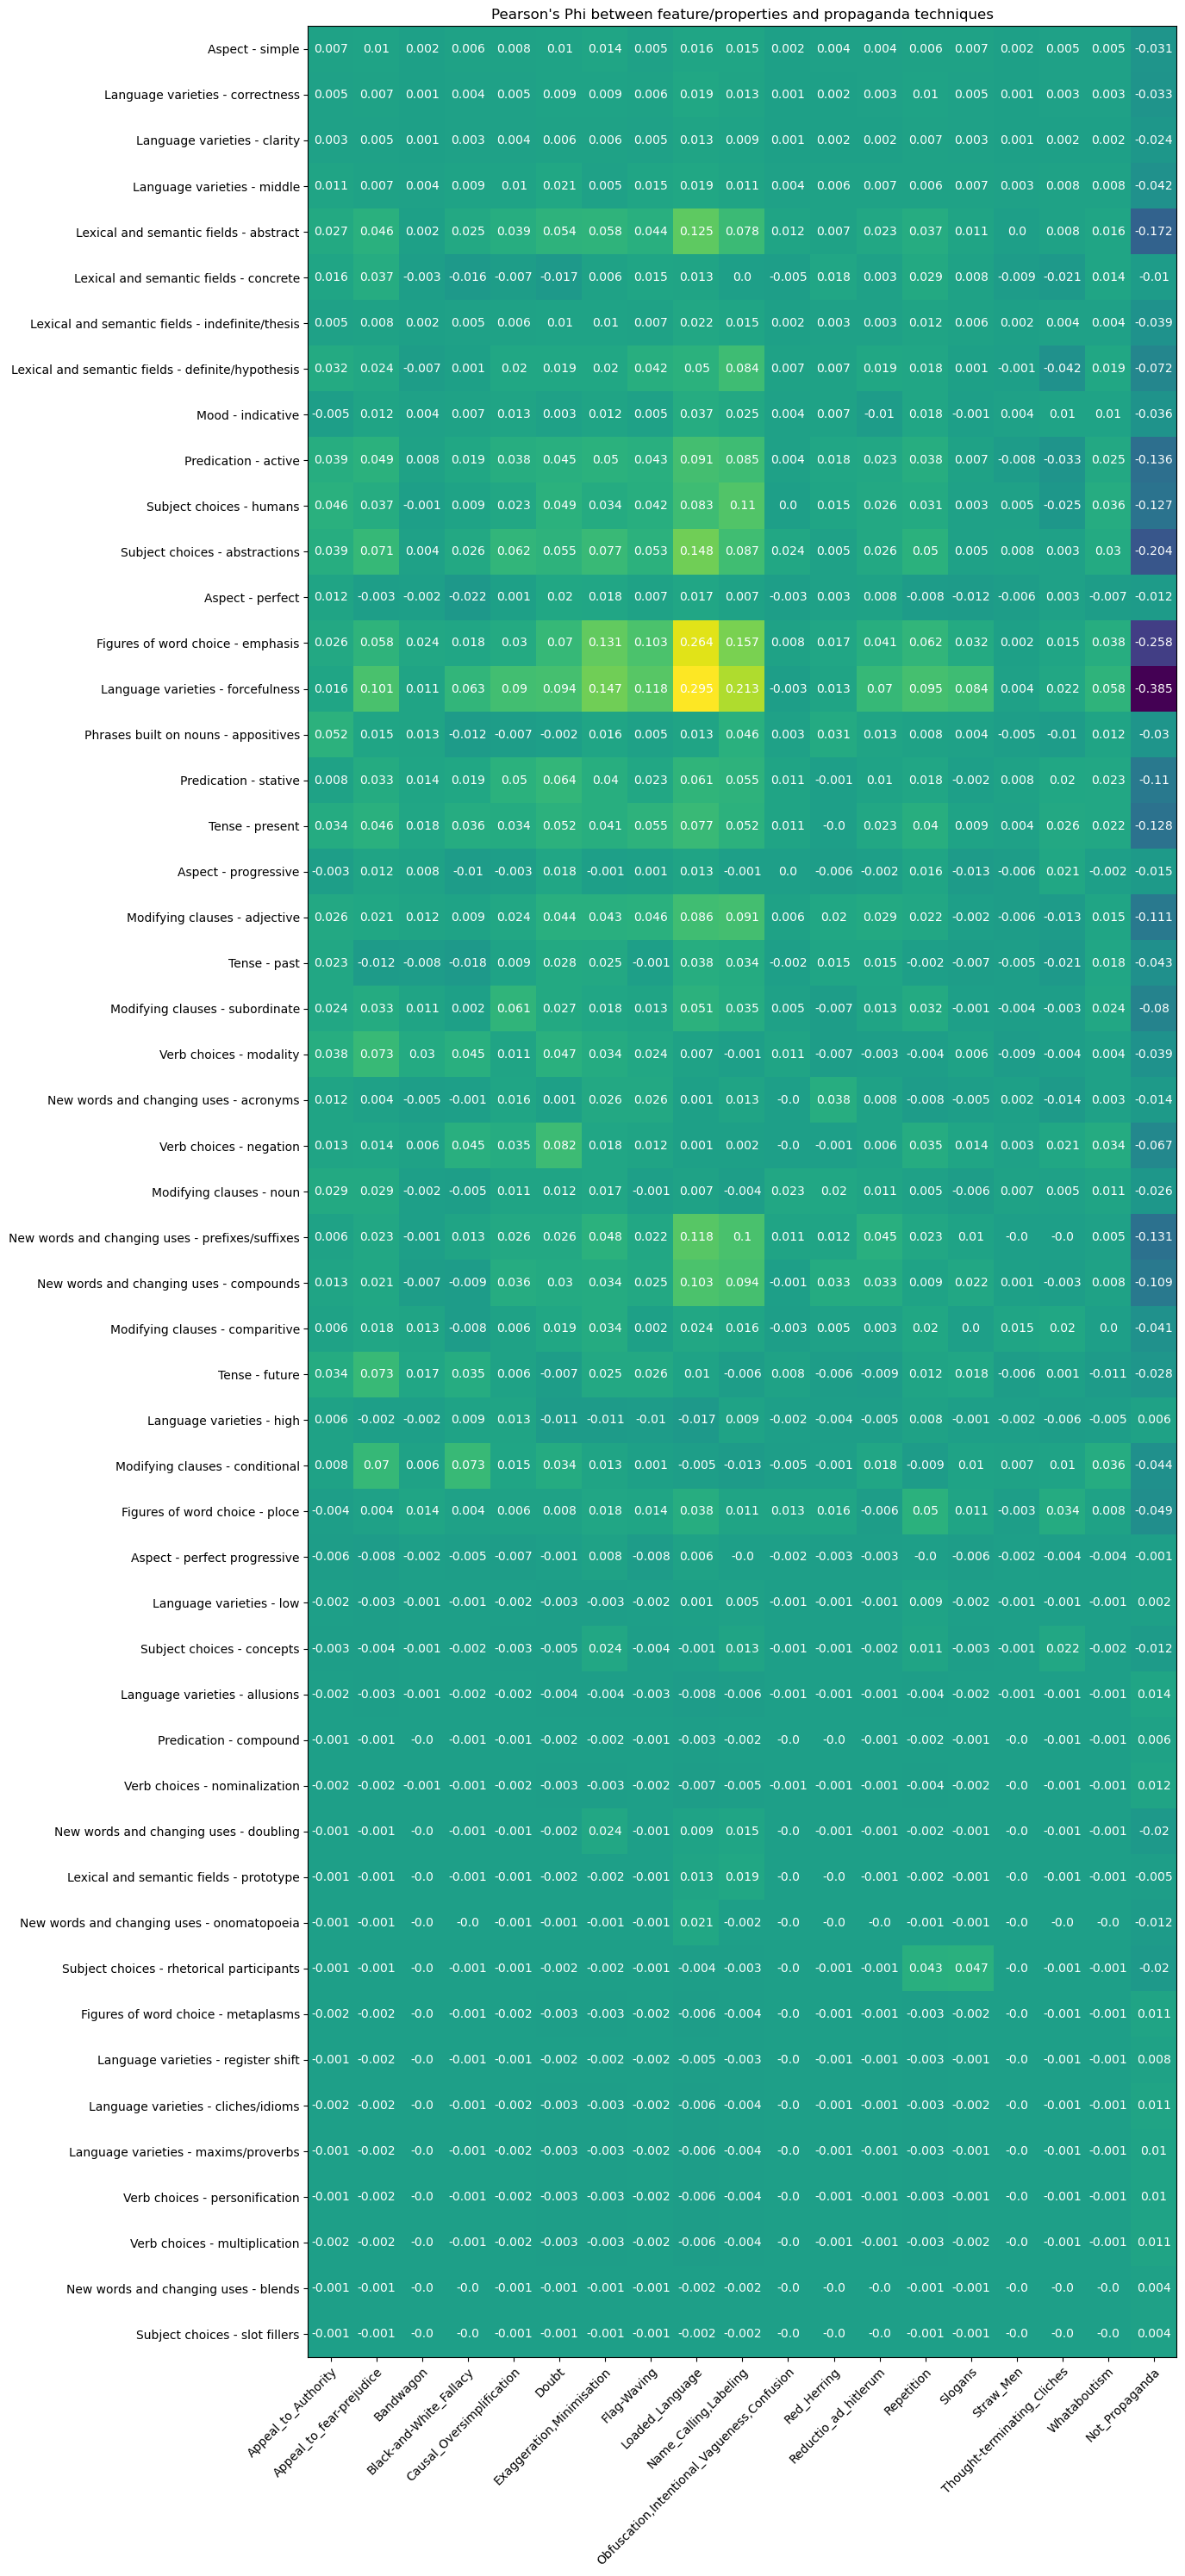

In [147]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

import math



_corrs = []
_props = []

for k,v in phi_coefficients.items():
    # f = feature_prop_dict[k]
    _props.append(k)
    v = [round(i,3) for i in v]
    _corrs.append(v)

_corrs = np.array(_corrs)

fig, ax = plt.subplots(figsize=[20,30])
im = ax.imshow(_corrs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(techniques)), labels=techniques)
ax.set_yticks(np.arange(len(_props)), labels=_props)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(_props)):
    for j in range(len(techniques)):
        text = ax.text(j, i, _corrs[i, j], ha="center", va="center", color="w")

ax.set_title("Pearson's Phi between feature/properties and propaganda techniques")
fig.tight_layout()
fig.savefig("phi_correlations.svg",format="svg")
plt.show()

## Pearson's r Correlation matrix

In [110]:
correlations.keys()

dict_keys(['Aspect - simple', 'Language varieties - correctness', 'Language varieties - clarity', 'Language varieties - middle', 'Lexical and semantic fields - abstract', 'Lexical and semantic fields - concrete', 'Lexical and semantic fields - indefinite/thesis', 'Lexical and semantic fields - definite/hypothesis', 'Mood - indicative', 'Predication - active', 'Subject choices - humans', 'Subject choices - abstractions', 'Aspect - perfect', 'Figures of word choice - emphasis', 'Language varieties - forcefulness', 'Phrases built on nouns - appositives', 'Predication - stative', 'Tense - present', 'Aspect - progressive', 'Modifying clauses - adjective', 'Tense - past', 'Modifying clauses - subordinate', 'Verb choices - modality', 'New words and changing uses - acronyms', 'Verb choices - negation', 'Modifying clauses - noun', 'New words and changing uses - prefixes/suffixes', 'New words and changing uses - compounds', 'Modifying clauses - comparitive', 'Tense - future', 'Language varieties

In [117]:
correlations

defaultdict(list,
            {'Aspect - simple': [[0.007027226374970033, 0.31368533874801796],
              [0.010414340293241349, 0.13539421559557244],
              [0.0022153790307546423, 0.7507705632573921],
              [0.005963019647877439, 0.3925860140521762],
              [0.008496043447134904, 0.22317996163677514],
              [0.009511321107168801, 0.17266610839886404],
              [0.013630509931603143, 0.05066305353361497],
              [0.004663753235057594, 0.5037157255849961],
              [0.0156122190382568, 0.025189130056227325],
              [0.015153865347134126, 0.02979815005419312],
              [0.002293190967394781, 0.7423223101829537],
              [0.003554413377549491, 0.6103285090862702],
              [0.004314540738440153, 0.5361886285669325],
              [0.005860596097385469, 0.40076712060833425],
              [0.007226631027372966, 0.3001511512844323],
              [0.0020509426060090243, 0.7687213509756362],
              [0.005337475

In [120]:
ordered_correlations

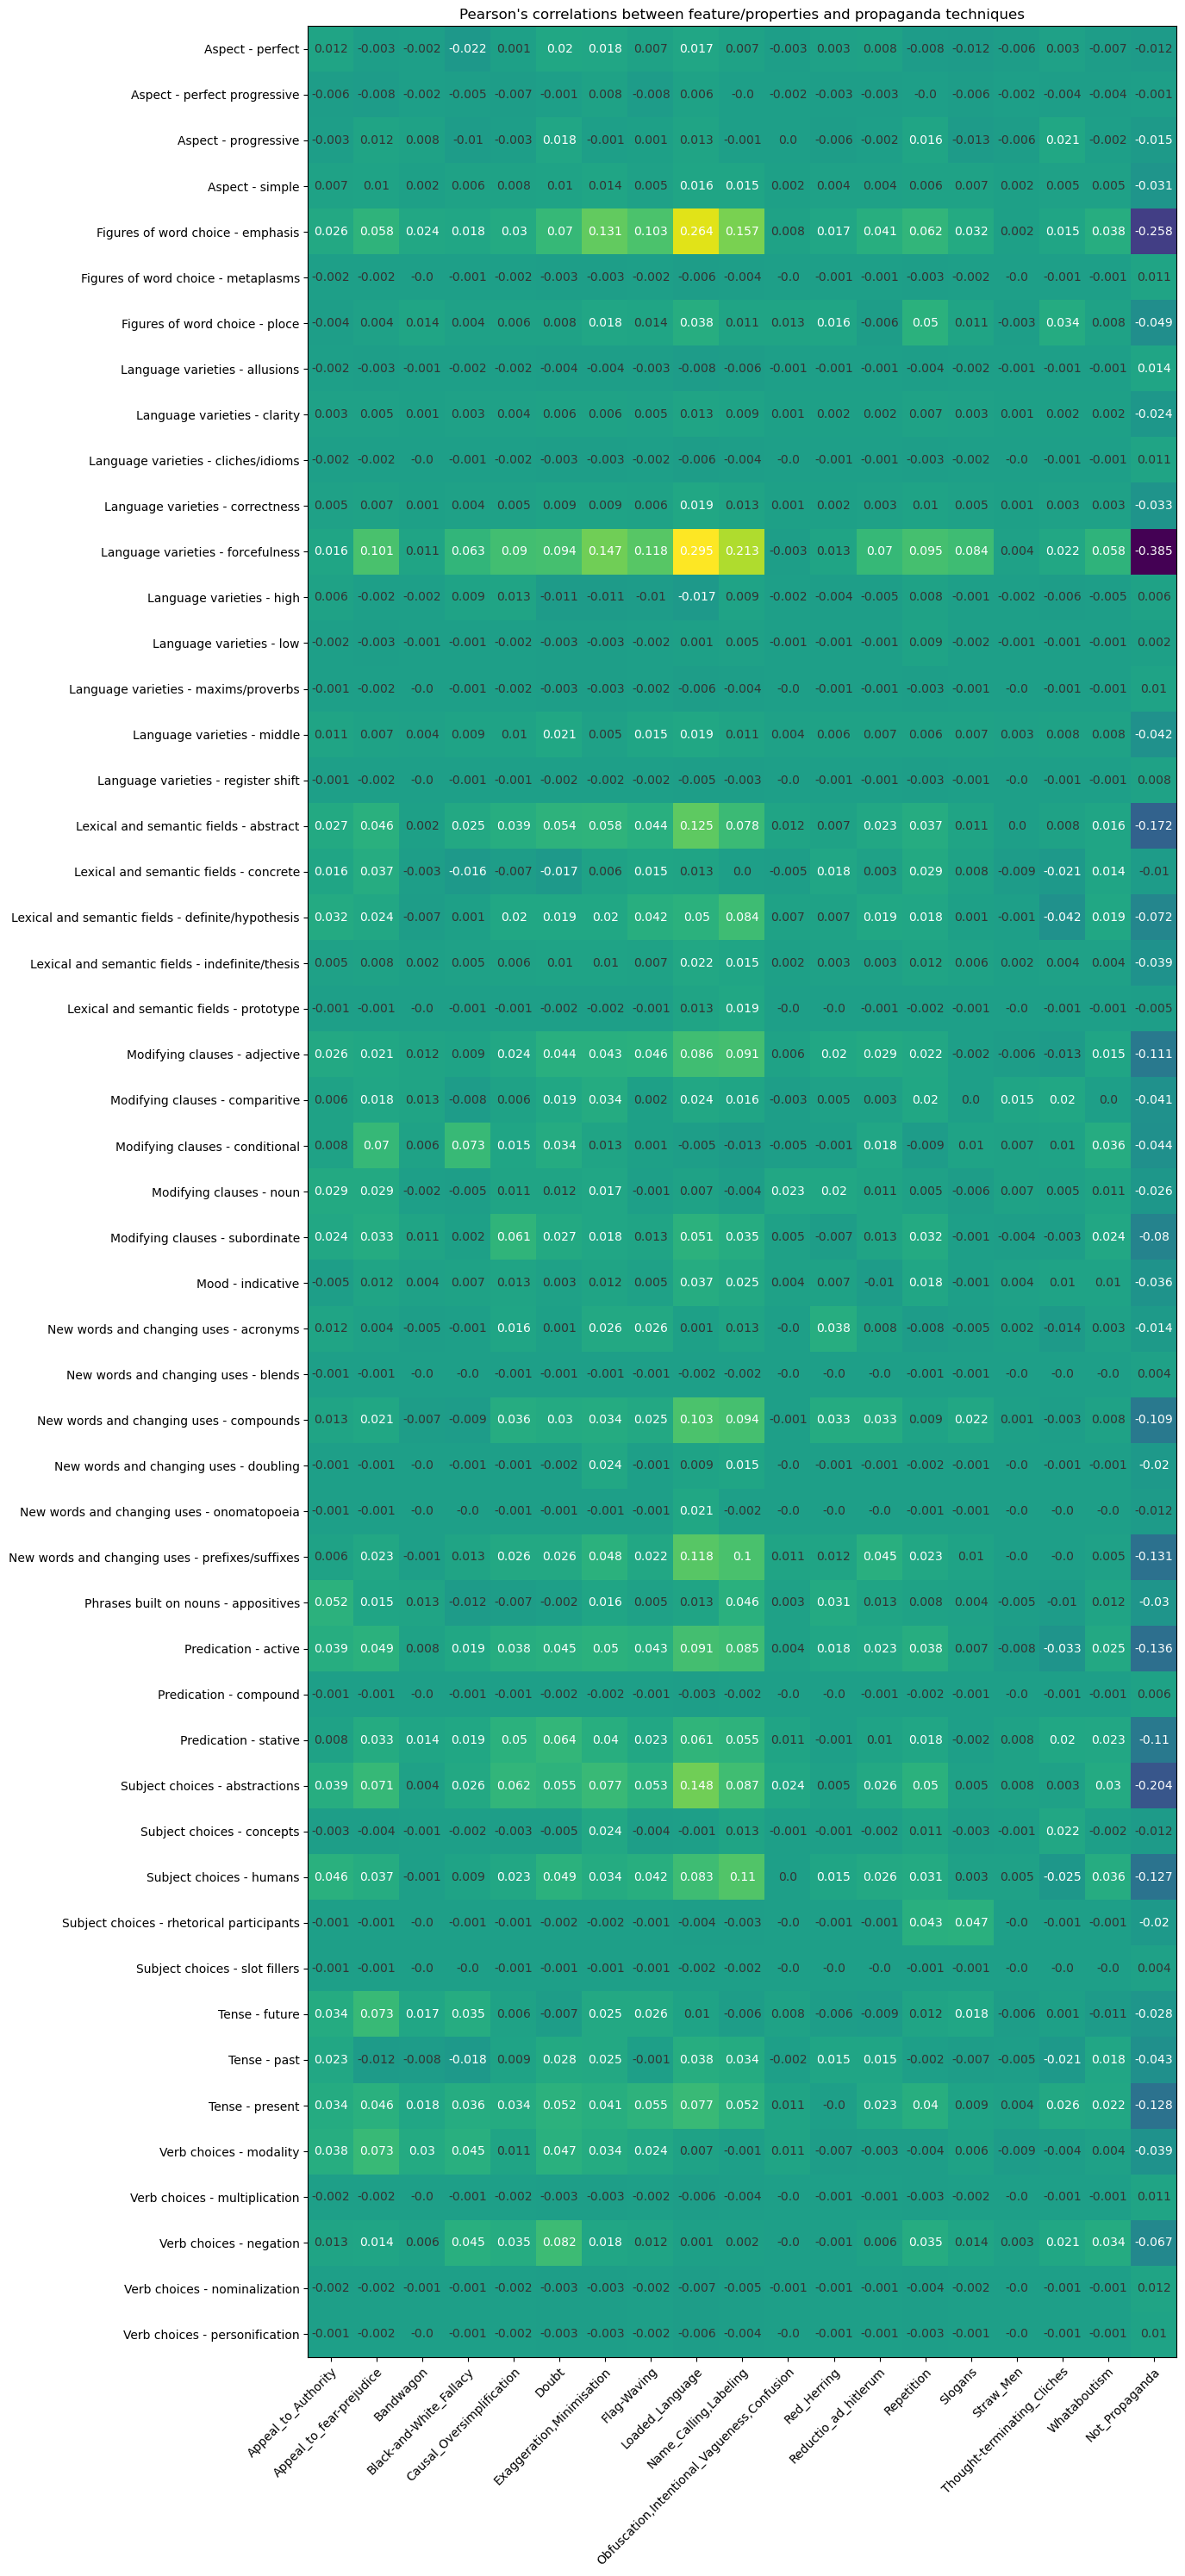

In [127]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

from collections import OrderedDict
ordered_correlations = OrderedDict(sorted(correlations.items()))

del ordered_correlations['simple']

_corrs = []
_props = []

for k,v in ordered_correlations.items():
    # f = feature_prop_dict[k]
    _props.append(k)
    v = [i.round(3) for i in list(np.array(v)[:,0])]
    _corrs.append(v)

_corrs = np.array(_corrs)

fig, ax = plt.subplots(figsize=[20,30])
im = ax.imshow(_corrs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(techniques)), labels=techniques)
ax.set_yticks(np.arange(len(_props)), labels=_props)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(_props)):
    for j in range(len(techniques)):
        if ordered_correlations[_props[i]][j][1] > 0.05:
            text = ax.text(j, i, _corrs[i, j],
                       ha="center", va="center", color="#333333")
        else:
            text = ax.text(j, i, _corrs[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Pearson's correlations between feature/properties and propaganda techniques")
fig.tight_layout()
fig.savefig("ptc_correlations_lg.png",format="png")
plt.show()

In [138]:
# For each propaganda technique, what are the commonly occuring combinations of features? 
# Perform market basket analysis per technique. Or, train a decision tree?


frequencies = defaultdict(list)

for k,v in Q_table.items():
    for idx, item in enumerate(v):
        frequencies[idx].append((item,k))
    
bar_chart_data = defaultdict(list)   
for k,v in frequencies.items():
    top_10 = sorted(v, reverse=True)[:10]
    bar_chart_data[k] = top_10

In [139]:
bar_chart_data

defaultdict(list,
            {0: [(140, 'Lexical and semantic fields - indefinite/thesis'),
              (140, 'Language varieties - middle'),
              (140, 'Language varieties - correctness'),
              (140, 'Language varieties - clarity'),
              (140, 'Aspect - simple'),
              (139, 'Predication - active'),
              (135, 'Mood - indicative'),
              (133, 'Lexical and semantic fields - abstract'),
              (130, 'Lexical and semantic fields - definite/hypothesis'),
              (129, 'Subject choices - humans')],
             1: [(305, 'Lexical and semantic fields - indefinite/thesis'),
              (305, 'Language varieties - correctness'),
              (305, 'Language varieties - clarity'),
              (305, 'Aspect - simple'),
              (302, 'Mood - indicative'),
              (302, 'Language varieties - middle'),
              (296, 'Lexical and semantic fields - abstract'),
              (294, 'Predication - active'),
    

# Cramer's V

In [ ]:
scipy.stats.contingency.association

"""
Calculates degree of association between two nominal variables.

The function provides the option for computing one of three measures of association between two nominal variables 
from the data given in a 2d contingency table: Tschuprow’s T, Pearson’s Contingency Coefficient and Cramer’s V.

measure the degree to which two nominal or ordinal variables are related, or the level of their association. 
This differs from correlation, although many often mistakenly consider them equivalent. Correlation measures 
in what way two variables are related, whereas, association measures how related the variables are. As such, 
association does not subsume independent variables, and is rather a test of independence. A value of 1.0 indicates 
perfect association, and 0.0 means the variables have no association.

Both the Cramer’s V and Tschuprow’s T are extensions of the phi coefficient. Moreover, due to the close relationship 
between the Cramer’s V and Tschuprow’s T the returned values can often be similar or even equivalent. They are 
likely to diverge more as the array shape diverges from a 2x2


"""

# Compare to the 30 gold standard sentences

# NOTE: 
## There arent' enough examples to calculate correlations with p values below 0.05. Not going to finish this exercise

1. predicted
2. gold labels

In [11]:
data_path = "data/V3/_FT_Maj_gpt3.5/"

In [12]:
f_name = "_V3_Figures_of_word_choice.csv"

In [13]:
df = pd.read_csv(data_path+f_name)[['technique','ground truth']]

In [15]:
import re
df['technique'] = df['technique'].apply(lambda x: "[18]" if x=="[]" else x)
df['technique'] = df['technique'].apply(lambda x:[int(i) for i in re.findall(r'\d+',x)])

In [18]:
df['techniques']= df['technique'].apply(lambda s: makeTArr(s))

In [20]:
import ast
df['ground truth'] = df['ground truth'].apply(lambda x: ast.literal_eval(x))

In [21]:
df.head()

,technique,ground truth,techniques
0,[0],[emphasis],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 12]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,[1],[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[1],[rhetorical_conditional],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[1],[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [257]:
df = df.explode('ground truth')

In [26]:
df['ground truth'] = df['ground truth'].apply(lambda x: 'none' if type(x) == float else str(x))

In [27]:
df['ground truth']

0                   ['emphasis']
1                             []
2                             []
3     ['rhetorical_conditional']
4                             []
5     ['rhetorical_conditional']
6                      ['ploce']
7                             []
8                             []
9                             []
10                            []
11                     ['ploce']
12                            []
13                            []
14               ['agnominatio']
15                     ['ploce']
16                            []
17                            []
18                            []
19                  ['emphasis']
20                     ['ploce']
21                            []
22                  ['emphasis']
23                            []
24                  ['emphasis']
25                  ['emphasis']
26                            []
27                  ['synonyms']
28                     ['ploce']
29                     ['ploce']
Name: grou

In [29]:
props = list(df['ground truth'].unique())
props

["['emphasis']",
 '[]',
 "['rhetorical_conditional']",
 "['ploce']",
 "['agnominatio']",
 "['synonyms']"]

In [31]:
def makePArr(s):
    _list = [0]*len(props)
    _list[props.index(s)]=1
    return _list
df['truths'] = df['ground truth'].apply(makePArr)

In [33]:
df

,technique,ground truth,techniques,truths
0,[0],['emphasis'],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0]"
1,"[1, 12]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
2,[1],[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
3,[1],['rhetorical_conditional'],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0]"
4,[1],[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
5,[1],['rhetorical_conditional'],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0]"
6,[1],['ploce'],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0]"
7,"[3, 8]",[],"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
8,"[6, 4]",[],"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"
9,"[5, 8]",[],"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]"


In [36]:
from collections import defaultdict
import scipy
correlations = defaultdict(list)
for i in range(0,19):
    for j in range(0,4):
        prop = props[j]
        
        x = df['truths'].apply(lambda x: x[j])
        y = df['techniques'].apply(lambda x: x[i])
        
        
        p_r, p = scipy.stats.pearsonr(x, y)

        correlations[prop].append([p_r,p])

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


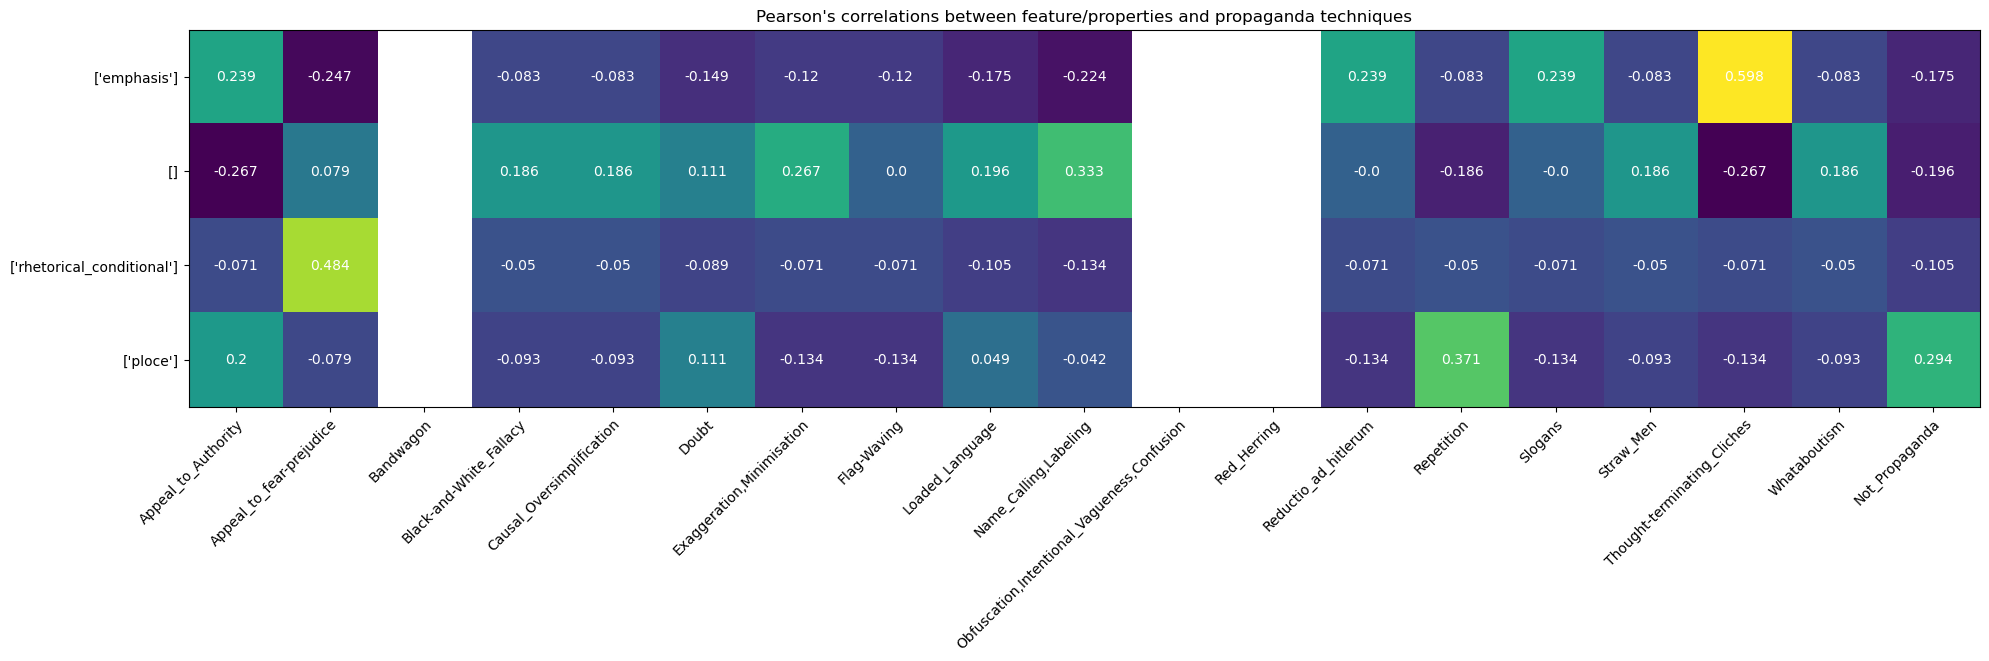

In [41]:
_corrs = []
_props = []

for k,v in correlations.items():
    # f = feature_prop_dict[k]
    # _props.append(f+" - "+k)
    _props.append(k)
    v = [i.round(3) for i in list(np.array(v)[:,0])]
    _corrs.append(v)

_corrs = np.array(_corrs)

fig, ax = plt.subplots(figsize=[20,30])
im = ax.imshow(_corrs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(techniques)), labels=techniques)
ax.set_yticks(np.arange(len(_props)), labels=_props)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(_props)):
    for j in range(len(techniques)):
        text = ax.text(j, i, _corrs[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Pearson's correlations between feature/properties and propaganda techniques")
fig.tight_layout()
plt.show()

In [20]:
!pwd

/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results


In [2]:
import pandas as pd
log = pd.read_csv("PTC_GPT.log",delimiter="\t", header=None, names=['level','date','message'])

In [3]:
log['message'] = log['message'].apply(lambda x: x.split(","))

In [4]:
def pad(l):
    if l and len(l) < 4:
        n = 4 - len(l)
        return l+[0]*n
    else:
        return [0]*4
    
log['message'] = log['message'].apply(pad)

In [6]:
import numpy as np
# log.explode('message').assign(message=["sid", "property","mess"]) #.reindex(["sid", "property","mess"], axis=1)
m = pd.DataFrame(np.vstack(log['message']).reshape(len(log), -1), columns=['sid','property','exception','other'])

In [7]:
result = pd.concat([log, m], axis=1)

In [8]:
log_df = result[['level', 'date', 'sid', 'property', 'exception', 'other']]

In [63]:
log_df.to_csv("PTC_GPT.log.csv", index=None)

In [9]:
log_df[log_df['level'] == 'WARNING ']

,level,date,sid,property,exception,other
0,WARNING,02/16/2024 02:59:49 PM,SID: 1,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
1,WARNING,02/16/2024 05:22:48 PM,SID: 1,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
2,WARNING,02/16/2024 05:40:08 PM,SID: 11,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
3,WARNING,02/16/2024 05:49:15 PM,SID: 16,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
4,WARNING,02/16/2024 05:56:17 PM,SID: 20,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
...,...,...,...,...,...,...
4670,WARNING,03/14/2024 11:13:27 AM,SID: 20516,Property: stative,Exception: JSONDecodeError - Unterminated str...,0
4671,WARNING,03/14/2024 11:30:29 AM,SID: 20527,Property: middle,Exception: JSONDecodeError - Unterminated str...,0
4672,WARNING,03/14/2024 11:37:10 AM,SID: 20531,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0
4673,WARNING,03/14/2024 11:40:39 AM,SID: 20533,Property: forcefulness,Exception: JSONDecodeError - Unterminated str...,0


In [10]:
log_df.loc[0]['exception']

' Exception: JSONDecodeError - Unterminated string starting at: line 1 column 33 (char 32)'

In [79]:
pd.set_option('display.max_rows', 100)
warning_distribution = log_df[log_df['level'] == 'WARNING '].groupby('property').count().sort_values('level',ascending=False).reset_index()

In [81]:
warning_distribution['property'] = warning_distribution['property'].apply(lambda x: x.replace("Property: ",""))

In [83]:
warning_distribution = warning_distribution[['property','level']]
warning_distribution = warning_distribution.rename(columns={'level':'count'})

In [86]:
# GPT Error distribution by property (number of occurances: 2,405,450 / 117 = 20,559)
warning_distribution['ratio'] = round(warning_distribution['count']/20599,2)
warning_distribution

,property,count,ratio
0,forcefulness,3042,0.15
1,stative,283,0.01
2,compound,240,0.01
3,active,144,0.01
4,0,99,0.00
5,high,64,0.00
6,maxims/proverbs,59,0.00
7,allusions,44,0.00
8,clarity,42,0.00
9,low,35,0.00


In [1]:
import pandas as pd

In [22]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

In [19]:
df.columns = ["Feature", "K." ,"J." ,"E." ,"GPT-4" ,"GPT-3.5"]

In [24]:
df.style.background_gradient(axis=None)

,Feature,K.,J.,E.,GPT-4,GPT-3.5
0,Aspect,0.364000,0.573000,0.320000,0.980000,0.568000
1,Emphasis,-0.023000,0.325000,0.314000,0.588000,0.389000
2,Fig.-of-argument,0.330000,0.101000,0.094000,0.925000,0.429000
3,Fig.-of-word-choice,0.171000,0.067000,0.047000,0.873000,0.342000
4,Language-of-origin,-0.101000,0.282000,0.042000,0.421000,0.353000
5,Language-varieties,0.074000,0.613000,0.126000,0.059000,0.157000
6,Lexical-fields,0.057000,0.269000,0.036000,0.364000,0.129000
7,Modifying-clauses,0.496000,0.355000,0.255000,0.759000,0.322000
8,Modifying-phrases,0.294000,0.543000,0.370000,0.160000,0.375000
9,Mood,0.458000,0.870000,0.846000,0.935000,0.734000


In [10]:
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [17]:
df[[1,2,3,4,5]].style.applymap(_color_red_or_green)

,1,2,3,4,5
0,0.364000,0.573000,0.320000,0.980000,0.568000
1,-0.023000,0.325000,0.314000,0.588000,0.389000
2,0.330000,0.101000,0.094000,0.925000,0.429000
3,0.171000,0.067000,0.047000,0.873000,0.342000
4,-0.101000,0.282000,0.042000,0.421000,0.353000
5,0.074000,0.613000,0.126000,0.059000,0.157000
6,0.057000,0.269000,0.036000,0.364000,0.129000
7,0.496000,0.355000,0.255000,0.759000,0.322000
8,0.294000,0.543000,0.370000,0.160000,0.375000
9,0.458000,0.870000,0.846000,0.935000,0.734000


In [7]:
df = pd.read_clipboard(header=None)

In [15]:
pd.to_numeric(df[1])
pd.to_numeric(df[2])
pd.to_numeric(df[3])
pd.to_numeric(df[4])
pd.to_numeric(df[5])
df

,0,1,2,3,4,5
0,Aspect,0.364,0.573,0.320,0.980,0.568
1,Emphasis,-0.023,0.325,0.314,0.588,0.389
2,Fig.-of-argument,0.330,0.101,0.094,0.925,0.429
3,Fig.-of-word-choice,0.171,0.067,0.047,0.873,0.342
4,Language-of-origin,-0.101,0.282,0.042,0.421,0.353
5,Language-varieties,0.074,0.613,0.126,0.059,0.157
6,Lexical-fields,0.057,0.269,0.036,0.364,0.129
7,Modifying-clauses,0.496,0.355,0.255,0.759,0.322
8,Modifying-phrases,0.294,0.543,0.370,0.160,0.375
9,Mood,0.458,0.870,0.846,0.935,0.734


In [11]:
df.style.applymap(_color_red_or_green)

TypeError: '<' not supported between instances of 'str' and 'int'